In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [17]:
data = pd.read_csv("accident.csv")
data["Survived"].value_counts()

Survived
1    101
0     99
Name: count, dtype: int64

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [102]:
data = data.dropna()
data = data.replace({'Yes': 1, 'No': 0})
data = data.replace({'Male': 1, 'Female': 0})

data["Survived"].value_counts()

Survived
1    100
0     96
Name: count, dtype: int64

In [90]:
y = data["Survived"]
x = data.drop("Survived", axis=1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=42)

In [91]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

RandomForestClassifier()

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_rf.predict(x_test))*100} %")

Le pourcentage de bien classés est de : 45.0 %


In [94]:
columns = list(x.columns)
columns


['Age', 'Gender', 'Speed_of_Impact', 'Helmet_Used', 'Seatbelt_Used']

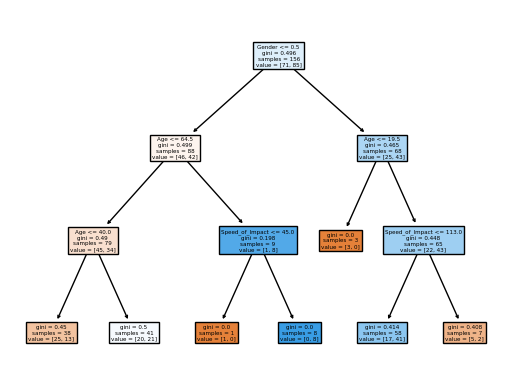

In [105]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X = x_train, y = y_train)
plot_tree(clf, feature_names= columns, filled=True);

In [109]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier(hidden_layer_sizes=(1,50,2), max_iter=1000, random_state=42, activation='relu')
model_mlp.fit(x_train, y_train)

# Prédictions sur les données de test
predictions_mlp = model_mlp.predict(x_test)

# Évaluation de l'efficacité du modèle
accuracy_mlp = accuracy_score(y_test, predictions_mlp)
print(f'Test accuracy pour MLPclassifier: {accuracy_mlp}')

Test accuracy pour MLPclassifier: 0.375


: 